In [2]:
##########################################
###### Import all necessary modules ######
##########################################


import torch
from  torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import time
import tarfile

In [22]:
###########################
# Define Test Transforms #
##########################
test_transforms= transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ])

In [5]:
################################
### Check Cuda Availability ####
################################
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [9]:
##################################
###### Defining Model Class ######
##################################
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()

        hidden1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=48, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=48),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=160, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=160),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden5 = nn.Sequential(
            nn.Conv2d(in_channels=160, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden6 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden7 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
            nn.Dropout(0.2)
        )
        hidden8 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
            nn.Dropout(0.2)
        )
        hidden9 = nn.Sequential(
            nn.Linear(192 * 7 * 7, 3072),
            nn.ReLU()
        )
        hidden10 = nn.Sequential(
            nn.Linear(3072, 3072),
            nn.ReLU()
        )

        self._features = nn.Sequential(
            hidden1,
            hidden2,
            hidden3,
            hidden4,
            hidden5,
            hidden6,
            hidden7,
            hidden8
        )
        self._classifier = nn.Sequential(
            hidden9,
            hidden10
        )
        self._digit_length = nn.Sequential(nn.Linear(3072, 7))
        self._digit1 = nn.Sequential(nn.Linear(3072, 11))
        self._digit2 = nn.Sequential(nn.Linear(3072, 11))
        self._digit3 = nn.Sequential(nn.Linear(3072, 11))
        self._digit4 = nn.Sequential(nn.Linear(3072, 11))
        self._digit5 = nn.Sequential(nn.Linear(3072, 11))

    def forward(self, x):
        x = self._features(x)
        x = x.view(x.size(0), 192 * 7 * 7)
        x = self._classifier(x)

        length_logits, digits_logits = self._digit_length(x), [self._digit1(x),
                                                               self._digit2(x),
                                                               self._digit3(x),
                                                               self._digit4(x),
                                                               self._digit5(x)]
        return length_logits, digits_logits

In [19]:
#######################################################################
###### process_image Function gets the image at a particular idx ######
#######################################################################


def process_image(csvfile, idx):
    df = pd.read_csv(csvfile)
    img_name = os.path.join(os.path.split(os.getcwd())[0], 'data', df['filename'][idx].replace("/", "\\"))
    image = Image.open(img_name) #image=Image.open(img_name)
        
    height=[]
    width=[]
    top=[]
    left=[]

    for i in range(5):
        bb = df['bbox%d'%(i+1)][idx]
        bb = bb[1:(len(bb)-1)]
        bb = bb.split(',')
        bb = [float(element) for element in bb]
        height.append(bb[3])
        width.append(bb[2])
        top.append(bb[1])
        left.append(bb[0])
            
    new_left = [ii for ii in left if ii != 0]
    new_top = [ii for ii in top if ii != 0]
        
    if new_left==[]:
        new_left.append(0)
        
    if new_top==[]:
        new_top.append(0)
            
    _left = int(min(new_left))
    upper = int(min(new_top))
    right = int(max(left)) + int(max(width))
    lower = int(max(top)) + int(max(height))
       
    _image = image.crop(box=(_left, upper, right, lower))
    
    labels=[]
    labels.append(int(df['len'][idx]))
        
    for i in range(5):
        num = df.iloc[idx]['num%d'%(i+1)]
        labels.append(int(num)+1)
    
    #resize and convert to np array
    _image = _image.resize([64,64])
    image_array = np.array(_image)
    #_image = image_array.reshape([64, 64, 3])
    image_array = Image.fromarray(image_array) #image_array = np.array(_image)
    labels_array = np.array(labels)
    labels_array = torch.from_numpy(labels_array).long()
        
    return image_array, labels_array

def load_model():
    classifier = torch.load('SVHN_model_checkpoint.tar', map_location=torch.device(device))
    model = Model()
    model.load_state_dict(classifier['model_state_dict'])
    model.eval()
    return model

--------------------------------------------------
Prediction accuracy is:  50.0 %
Predicted Labels are:  [3, 6, 7]
Predicted Length is:  3
--------------------------------------------------
Actual Labels are:  [3, 6, 1, 7]
Actual Length is:  4
--------------------------------------------------


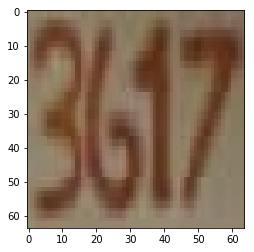

In [48]:
###########################
####### Inference #########
###########################

classifier = torch.load('SVHN_model_checkpoint.tar', map_location=device)
inf_model = Model()
inf_model.load_state_dict(classifier['model_state_dict'])
inf_model.eval()

#prediction idx here
idx = 6780
image, labels = process_image('test.csv', idx)
plt.imshow(image)
t_image = test_transforms(image).view(1, 3, 64, 64)


length_logits, digits_logits = inf_model(t_image)

_, length_top_class = length_logits.topk(1, dim=1)
                    
digits_top_class = []
                    
for i in range(5):
    _, _digits_top_class = digits_logits[i].topk(1, dim=1)
    digits_top_class.append(_digits_top_class)
    
accuracy = 0
equals = length_top_class == labels[0].view(*length_top_class.shape)
accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
for i in range(5):
    equals = digits_top_class[i] == labels[i+1]
    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
    
    
digits_logits
print("-"*50)
print("Prediction accuracy is: ", (accuracy/6)*100, "%")
print("Predicted Labels are: ",[(i.item()-1) for i in digits_top_class if i!= 0])
print("Predicted Length is: ", length_top_class.item())
print("-"*50)
print("Actual Labels are: ",[(i.item()-1) for i in labels.data[1:] if i!= 0])
print("Actual Length is: ",labels[0].item())
print("-"*50)


In [36]:
print("Actual Labels are: ",[(i.item()-1) for i in labels.data[1:] if i!= 0])

Actual Labels are:  [2, 0]


In [34]:
l = [((i.item())-1) for i in labels.data[1:] if i!= 0]

In [35]:
l

[2, 0]